In [36]:
%matplotlib inline

from math import prod, inf
import numpy as np
import torch
from mugnier.libs import backend
from mugnier.libs.quantity import Quantity as __
from mugnier.heom.hierachy import ExtendedDensityTensor, SineExtendedDensityTensor, Hierachy, SineHierachy
from mugnier.heom.bath import BoseEinstein, Drude, DiscreteVibration, Correlation
from mugnier.operator.spo import Integrator

from matplotlib import pyplot as plt


- Define the models

In [37]:
# System settings:
e = __(5000, '/cm').au
v = __(0, '/cm').au
h = backend.array([[-e, v], [v, e]])
op = backend.array([[-1.0, 0.0], [0.0, 1.0]])
rdo = backend.array([[0.5, 0.5], [0.5, 0.5]])

# Bath settings:
beta = None
#beta = __(1 / 300, '/K').au
distr = BoseEinstein(n=0, beta=beta)

# HEOM basis settings:
scale=1.0
dim = 20
start, stop = (-16, 16)
include_drude = True
include_boson = False


In [38]:
def test_hierachy_coh(use_dvr=True):
    corr = Correlation(distr)
    if include_drude:
        # lambda sol: 250 -- 1400
        corr +=  Drude(__(100, '/cm').au, __(50, '/cm').au, distr)
    if include_boson:
        corr += DiscreteVibration(__(1500, '/cm').au, __(500, '/cm').au, distr)
    k_max = corr.k_max 
    corr.print()

    if not use_dvr:
        Hierachy.scale_factor = scale
        heom_op = Hierachy(h, op, corr, [dim] * k_max)
        s = ExtendedDensityTensor(rdo, [dim] * k_max)
    else:
        SineHierachy.scale_factor = scale
        heom_op = SineHierachy(h, op, corr, [(start, stop, dim)] * k_max)
        s = SineExtendedDensityTensor(rdo, [(start, stop, dim)] * k_max)
    solver = Integrator(heom_op, s)

    length = prod(s.shape(s.root))
    return solver.split_diff_op(s.root).reshape((length, length))


- Test eigenvalues of the generators 

Correlation coefficents:
            c: [0.-2.07601909e-07j];
            (c* = [0.+2.07601909e-07j];)
            gamma: [-0.00022782+0.j].
        
f_0 = 1.0


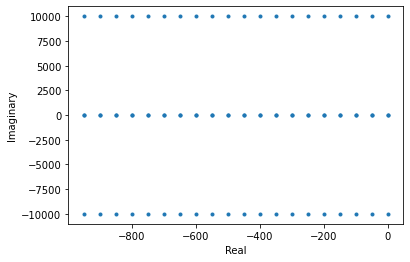

In [39]:
diff = test_hierachy_coh(use_dvr=False)

l = torch.linalg.eigvals(diff)
re, im = l.cpu().real, l.cpu().imag
re = [__(r).convert_to('/cm').value for r in re]
im = [__(i).convert_to('/cm').value for i in im]
plt.plot(re, im, '.')
plt.xlabel('Real')
plt.ylabel('Imaginary')

if include_drude and include_boson:
    fname = 'all_heom'
elif include_boson:
    fname = 'discrete_heom'
elif include_drude:
    fname = 'drude_heom'
else:
    fname = 'dummy_heom' 

plt.savefig(fname + '.pdf') 

- Test Eigenvalues for DVR-HEOM

Correlation coefficents:
            c: [0.-2.07601909e-07j];
            (c* = [0.+2.07601909e-07j];)
            gamma: [-0.00022782+0.j].
        
f_0 = 1.0


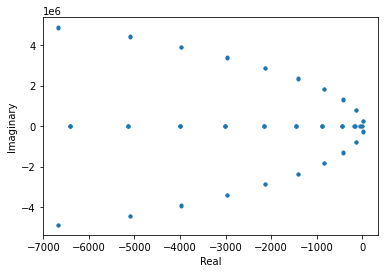

In [40]:
diff = test_hierachy_coh(use_dvr=True)
l = torch.linalg.eigvals(diff)
re, im = l.real, l.imag
re = [__(r).convert_to('/cm').value for r in re]
im = [__(i).convert_to('/cm').value for i in im]
plt.plot(re, im, '.')
# plt.xlim(-1, 1)
# plt.ylim(-1.5, 1.5)
plt.xlabel('Real')
plt.ylabel('Imaginary')

if include_drude and include_boson:
    fname = 'all_dvr'
elif include_boson:
    fname = 'discrete_dvr'
elif include_drude:
    fname = 'drude_dvr'
else:
    fname = 'dummy_dvr' 

plt.savefig(fname + '.pdf') 